In [2]:
%pip install symfit
from sympy import *
from symfit import *
import numpy as np

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
n = 2  # Number of robots
m = 2  # Number of lookahead time steps
N = 100  # Number of data points
DELTA = 1  # Sampling interval
objective = "Baricenter"  # Objective function, also determines l

# Process Dynamics

##
We define the update function $up\colon \mathbb{R}^{n \times 2} \times  \mathbb{R}^{m \times n \times 2} \to \mathbb{R}^{n \times 2}$ by: $$up(r,v)=r+\Delta \sum_{i=0}^m v_i$$


In [4]:
# Define the position update function
def up(robots, speed_vectors):
    return robots + DELTA * sum(speed_vectors)

# Test the function
robots = np.array([[1, 1], [2, 2], [3, 3]])
speed_vectors = np.array(
    [[[1, 1], [2, 2], [3, 3]], [[1, -2], [2, -4], [3, -6]], [[-2, 1], [-4, 2], [-6, 3]]]
)

assert np.allclose(up(robots, speed_vectors), robots)

#
Define the barycenter objective function $f\colon \mathbb{R}^{n \times 2} \to \mathbb{R}^{l}$, where $l=2$ as: $$f(r) := \frac{1}{n}\sum_{i=1}^{n} r_i$$

In [35]:
################# Define the barycenter objective function
def barycenter(robots):
    return sum(robots) / len(robots)


# Test that the barycenter is correct
points = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
b = barycenter(points)
assert np.allclose(b, np.array([4, 5]))


################# Define the formation objective functions
def formation(robots):
    if len(robots) < 2:
        return robots  # Return as it is if only one point or empty list

    first_point = robots[0]  # Get the first point
    mapped_points = []

    for point in robots:
        difference = [point[0] - first_point[0], point[1] - first_point[1]]
        mapped_points.append(difference)

    return mapped_points


# Test that the formation function is correct
points = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
form = formation(points)
assert np.allclose(form, np.array([[0, 0], [2, 2], [4, 4], [6, 6]]))


################# Define the obstacles objective functions

# Obstacle positions are given as a list of tuples
obstacles_pos = [(1, 1), (2, 3), (0, 0), (0, 2)]  

# Threshold distance to obstacles
threshold = 0.2

# This function returns the distance to the closest obstacle for each robot
def obstacles(robots):
    distances = np.zeros(len(robots))

    for i, robot in enumerate(robots):
        min_distance = float("inf")

        for obstacle in obstacles_pos:
            distance = np.linalg.norm(robot - obstacle)
            if distance < threshold and distance < min_distance:
                min_distance = distance

        distances[i] = min_distance

    # Replace all float("inf") in distances with zero
    return np.where(distances == float("inf"), 0, distances).sum()

# Test that the compute_accumulated_distances function is correct
robots = np.array([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06], [1.97, 2.98]])
assert np.allclose(obstacles(robots), 0.186518)


objectives = {"Baricenter": barycenter, "Formation": formation, "Obstacles": obstacles}
ls = {"Baricenter": 2, "Formation": n - 1, "Obstacles": 1}

# This is our only objective function for the time being
f = objectives[objective]
l = ls[objective]

#####
The function that we are going to fit is $\delta\colon \mathbb{R}^{n \times 2} \times  \mathbb{R}^{m \times n \times 2} \to \mathbb{R}^{l}$ defined by 
$$\delta(r,v) := f(up(r,v)) - f(r)$$

In [51]:
def delta(r, v):
    return tuple(f(up(r, v)) - f(r))

# Test that the delta function is correct
r = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
v = np.array([[[1, 1], [2, 2], [3, 3], [4, 4]]])
assert np.allclose(delta(r, v), np.array([[2.5, 2.5]]))

# Model Fitting

## Generation of a data set

We draw the following vectors with uniformly distributed random entries in the range $[-1,1]$:
* $\hat p_1,\dots,\hat p_N \in \mathbb{R}^{n \times 2}$ 
* $\hat v_1,\dots,\hat v_N \in \mathbb{R}^{m \times n \times 2}$ 

Let $\bar p_i \in \mathbb{R}^{2n}$ and $\bar v_i \in \mathbb{R}^{2nm}$ be flattened versions of, respectively, $\hat p_i$ and $\hat v_i$, for each $i \in 1,\dots,N$. 

Our dataset is: $\{ (\bar p_i, \bar v_i) \mapsto \delta(\hat p_i, \hat v_i ) \colon i=1,\dots,N \}$

In [52]:

p_ = np.random.uniform(low=-1, high=1, size=(N, n, 2))
v_ = np.random.uniform(low=-1, high=1, size=(N, m, n, 2))

y_ = np.array([delta(p_[i], v_[i]) for i in range(N)])

v_flatted = v_.reshape(N, 2 * n * m).T
p_flatted = p_.reshape(N, 2 * n).T

# Create a dtataset for Fit
pdict = {f"p_{i}": p_flatted[i] for i in range(2 * n)}
vdict = {f"v_{i}": v_flatted[i] for i in range(2 * n * m)}
ydict = {f"y_{i}": y_.T[i] for i in range(l)}

## Variables

The input variables for our model are $p \in \mathbb{R}^{2n}$ and $v \in \mathbb{R}^{2nm}$

In [53]:
p = np.array([[Variable(f"p_{i}")] for i in range(2 * n)])

v = np.array([[Variable(f"v_{i}")] for i in range(2 * n * m)])

## Parameters
The parameters for each $(i,j) \in \{0,\dots, l-1\} \times \{0,\dots, 2nm-1\}$ are
* $M_{i,j} \in \mathbb{R}^{2n \times 2n}$
* $d_{i,j} \in \mathbb{R}^{1 \times 2n}$
* $c_{i,j} \in \mathbb{R}$

In [6]:
def M(ii, jj):
    def param(i, j):
        i, j = (max(i, j), min(i, j))
        return Parameter(f"M_{ii}_{jj}__{i}__{j}")

    return np.array([[param(i, j) for i in range(2 * n)] for j in range(2 * n)])


def d(ii, jj):
    return np.array([[Parameter(f"d{ii}_{jj}__{i}") for i in range(2 * n)]])


def c(ii, jj):
    return Parameter(f"c_{ii}__{jj}")

[[M_0_0__0__0 M_0_0__1__0 M_0_0__2__0 M_0_0__3__0]
 [M_0_0__1__0 M_0_0__1__1 M_0_0__2__1 M_0_0__3__1]
 [M_0_0__2__0 M_0_0__2__1 M_0_0__2__2 M_0_0__3__2]
 [M_0_0__3__0 M_0_0__3__1 M_0_0__3__2 M_0_0__3__3]]


## Model 
The model that we will fit to the data if the form $J(p)v$ where $J(p) \in \mathbb{R}^{l \times 2nm}$ is defined by
$$J_{i,j} := p^T M_{i,j} p + d_{i,j}p + c_{i,j}$$


In [55]:
J = np.array(
    [
        [((p.T) @ M(i, j) @ p + d(i, j) @ p + c(i, j))[0, 0] for i in range(2 * n * m)]
        for j in range(l)
    ]
)

mdl = J @ v

model = {Variable(f"y_{i}"): mdl[i, 0] for i in range(l)}
model

{y_0: v_0*(c_0__0 + d0_0__0*p_0 + d0_0__1*p_1 + d0_0__2*p_2 + d0_0__3*p_3 + p_0*(M_0_0__0__0*p_0 + M_0_0__0__1*p_1 + M_0_0__0__2*p_2 + M_0_0__0__3*p_3) + p_1*(M_0_0__1__0*p_0 + M_0_0__1__1*p_1 + M_0_0__1__2*p_2 + M_0_0__1__3*p_3) + p_2*(M_0_0__2__0*p_0 + M_0_0__2__1*p_1 + M_0_0__2__2*p_2 + M_0_0__2__3*p_3) + p_3*(M_0_0__3__0*p_0 + M_0_0__3__1*p_1 + M_0_0__3__2*p_2 + M_0_0__3__3*p_3)) + v_1*(c_1__0 + d1_0__0*p_0 + d1_0__1*p_1 + d1_0__2*p_2 + d1_0__3*p_3 + p_0*(M_1_0__0__0*p_0 + M_1_0__0__1*p_1 + M_1_0__0__2*p_2 + M_1_0__0__3*p_3) + p_1*(M_1_0__1__0*p_0 + M_1_0__1__1*p_1 + M_1_0__1__2*p_2 + M_1_0__1__3*p_3) + p_2*(M_1_0__2__0*p_0 + M_1_0__2__1*p_1 + M_1_0__2__2*p_2 + M_1_0__2__3*p_3) + p_3*(M_1_0__3__0*p_0 + M_1_0__3__1*p_1 + M_1_0__3__2*p_2 + M_1_0__3__3*p_3)) + v_2*(c_2__0 + d2_0__0*p_0 + d2_0__1*p_1 + d2_0__2*p_2 + d2_0__3*p_3 + p_0*(M_2_0__0__0*p_0 + M_2_0__0__1*p_1 + M_2_0__0__2*p_2 + M_2_0__0__3*p_3) + p_1*(M_2_0__1__0*p_0 + M_2_0__1__1*p_1 + M_2_0__1__2*p_2 + M_2_0__1__3*p_3) + p_

## Fitting the model to the data

In [56]:
fit = Fit(model, **ydict, **pdict, **vdict)
fit_result = fit.execute()
print(fit_result)


Parameter Value        Standard Deviation
M_0_0__0__01.713480e-01 None
M_0_0__0__14.305431e-01 None
M_0_0__0__24.060965e-02 None
M_0_0__0__3-3.048829e-01 None
M_0_0__1__04.305431e-01 None
M_0_0__1__13.084041e-01 None
M_0_0__1__2-8.602040e-02 None
M_0_0__1__3-6.675382e-02 None
M_0_0__2__04.060965e-02 None
M_0_0__2__1-8.602040e-02 None
M_0_0__2__23.393684e-01 None
M_0_0__2__3-4.944606e-01 None
M_0_0__3__0-3.048829e-01 None
M_0_0__3__1-6.675382e-02 None
M_0_0__3__2-4.944606e-01 None
M_0_0__3__35.276308e-01 None
M_0_1__0__01.406263e-01 None
M_0_1__0__13.988088e-01 None
M_0_1__0__22.986087e-02 None
M_0_1__0__3-3.312870e-01 None
M_0_1__1__03.988088e-01 None
M_0_1__1__12.481337e-01 None
M_0_1__1__2-8.153498e-02 None
M_0_1__1__3-7.980251e-02 None
M_0_1__2__02.986087e-02 None
M_0_1__2__1-8.153498e-02 None
M_0_1__2__23.297791e-01 None
M_0_1__2__3-4.884191e-01 None
M_0_1__3__0-3.312870e-01 None
M_0_1__3__1-7.980251e-02 None
M_0_1__3__2-4.884191e-01 None
M_0_1__3__34.483179e-01 None
M_1_0__0__0-7

## Save results to a file

In [57]:
# Save the fit_result to a file
import os
import pickle
import datetime

# Direcory name using the parameters
directory_name = f"results/{objective}_{n}_{m}_{N}_{DELTA}"

# Create a unique file name using the current date and time
file_name = f'results-{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'

# Create the directory if it does not exist
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

# Save the fit_result to a file    
with open(directory_name + "/" + file_name, "wb") as f:
    pickle.dump(fit_result, f)

# Load the fit_result from a file
with open(directory_name + "/" + file_name, "rb") as f:
    fit_result2 = pickle.load(f)

# Check that the loaded fit_result is the same as the original
fit_result2

In [58]:

# Map the vlue to each element of the matrix M
def M_value(ii, jj):
    return np.array(
        [
            [fit_result.value(M(ii, jj)[i, j]) for i in range(2 * n)]
            for j in range(2 * n)
        ]
    )

M_value(3, 1)

array([[ 0.60584998,  0.18424549, -0.29690832,  0.29580902],
       [ 0.18424549,  0.21796383,  0.16500997, -0.06244634],
       [-0.29690832,  0.16500997, -0.02801594,  0.48306397],
       [ 0.29580902, -0.06244634,  0.48306397,  0.05298186]])

# Simulations

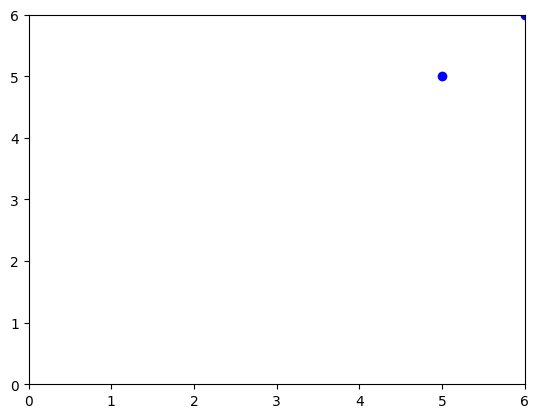

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def null_space_behavior(robot_positions, goal_positions):
    # Calculate the desired motion vector
    desired_motion = np.sum(goal_positions - robot_positions, axis=0)

    # Calculate the null space projection matrix
    null_space_projection = np.eye(len(robot_positions[0])) - np.linalg.pinv(robot_positions).dot(robot_positions)

    # Calculate the null space motion vector
    null_space_motion = null_space_projection.dot(desired_motion)

    # Add the null space motion to the desired motion
    total_motion = desired_motion + null_space_motion

    return total_motion

def update_frame(frame):
    global robot_positions, goal_positions, ax, scatter

    # Calculate the total motion vector
    total_motion = null_space_behavior(robot_positions, goal_positions)

    # Update the robot positions
    robot_positions += total_motion * 0.1

    # Update the scatter plot
    scatter.set_offsets(robot_positions)

    return scatter,

# Robot positions and goal positions
robot_positions = np.array([[1.0, 1.0], [2.0, 2.0], [3.0, 3.0]], dtype=np.float64)
goal_positions = np.array([[4.0, 4.0], [4.0, 4.0], [4.0, 4.0]], dtype=np.float64)

# Create a figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

# Create a scatter plot of the initial robot positions
scatter = ax.scatter(robot_positions[:, 0], robot_positions[:, 1], c='blue', marker='o')

# Define the animation
animation = animation.FuncAnimation(fig, update_frame, frames=100, interval=200, blit=True)

# Convert the animation to HTML5 video format
html_animation = animation.to_html5_video()

# Display the animation
HTML(html_animation)

